## Results needed:

Calibration curve for each detector

# Step 1:

* Upload data
* Plot counts vs channels - counts in bins

In [1]:
#!pip install lmfit

In [2]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib notebook

In [3]:
def parse_spe_files(filename):
    IS_DATA = False
    headers = {}
    data = []

    current_key = None
    current_value_lines = []

    with open(filename) as file:
        for line in file:
            line = line.strip()

            # detect start of data section
            if line == "$DATA:":
                # save the last header value before switching
                if current_key is not None:
                    headers[current_key] = "\n".join(current_value_lines).strip()
                IS_DATA = True
                continue

            # handle header lines
            if not IS_DATA:
                if line.startswith("$"):
                    # save previous header (if exists)
                    if current_key is not None:
                        headers[current_key] = "\n".join(current_value_lines).strip()
                    
                    # start a new header
                    current_key = line.strip()
                    current_value_lines = []
                else:
                    current_value_lines.append(line)
            else:
                # inside data section
                if line.startswith("0 1023"):
                    continue
                try:
                    counts = float(line.strip())
                    data.append(counts)
                except ValueError:
                    # silently skip non-data lines
                    continue

    # in case file doesn’t end with $DATA:
    if not IS_DATA and current_key is not None:
        headers[current_key] = "\n".join(current_value_lines).strip()

    # build data dictionary
    channels = np.arange(len(data))
    counts = np.array(data)

    return headers, channels, counts

In [4]:
def counts_per_sec(counts, exposure_time):
    counts_per_sec = counts / exposure_time
    return counts_per_sec

In [5]:
def plot_spectra(bkg_file, file):
    headers, channels, counts = parse_spe_files(file)
    bkg_headers, bkg_channels, bkg_counts = parse_spe_files(bkg_file)
    
    meas_bkg = bkg_headers["$MEAS_TIM:"]
    time_bkg = meas_bkg.split(" ")
    bkg_exp_time = int(time_bkg[0])
    
    bkg_counts_per_sec = counts_per_sec(np.array(bkg_counts), bkg_exp_time)
    
    meas_time = headers["$MEAS_TIM:"]
    time = meas_time.split(" ")
    exposure_time = int(time[0])
    
    counts_sec = counts_per_sec(np.array(counts), exposure_time)
    
    counts_minus_bkg = (np.array(counts_sec) - np.array(bkg_counts_per_sec)).flatten()
    
    if "Am" in file:
        title = "$Am_{241}$"
        
    if "Co" in file:
        title = "$Co_{60}$"
        
    if "Ba" in file:
        title = "$Ba_{133}$"
        
    if "Cs" in file:
        title = "$Cs_{137}$"
    
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(channels, counts_minus_bkg, label=f"{title} Spectrum")
    ax.set_title(f"{title} Spectrum BGO Detector")
    ax.set_xlabel("Channels")
    ax.set_ylabel("Counts/sec")
    plt.tight_layout()
    plt.show()
    
    return headers, channels, counts_sec, counts_minus_bkg

In [6]:
BGO_bkg_file = "BGO_Bck_10min.Spe"
BGO_Ba = "BGO_Ba_direct.Spe"

In [7]:
BGO_Ba_headers, BGO_Ba_channels, BGO_Ba_counts_sec, BGO_Ba_counts_minus_bkg = plot_spectra(BGO_bkg_file, BGO_Ba)

<IPython.core.display.Javascript object>

In [8]:
BGO_Co = "BGO_Co_60_direct.Spe"

In [9]:
BGO_Co_headers, BGO_Co_channels, BGO_Co_counts_sec, BGO_Co_counts_minus_bkg = plot_spectra(BGO_bkg_file, BGO_Co)

<IPython.core.display.Javascript object>

In [10]:
BGO_Am = "BGO_Am_241_direct.Spe"

In [11]:
BGO_Am_headers, BGO_Am_channels, BGO_Am_counts_sec, BGO_Am_counts_minus_bkg = plot_spectra(BGO_bkg_file, BGO_Am)

<IPython.core.display.Javascript object>

In [12]:
BGO_Cs = "BGO_Cs137_direct.Spe"
BGO_Cs_headers, BGO_Cs_channels, BGO_Cs_counts_sec, BGO_Cs_counts_minus_bkg = plot_spectra(BGO_bkg_file, BGO_Cs)

<IPython.core.display.Javascript object>

* Use curve fit to fit Gaussian to peaks
* popt 3 & 4 is an x and y coord of the peak
* Get energy of peak from website
* Assign energy to y value, get channel from x value
* Find energies and channels annd fit linear relationship

In [13]:
from lmfit import Model
from lmfit.models import GaussianModel

* amp = amp
* cen = mu
* wid = sigma

In [14]:
from scipy.signal import find_peaks

In [15]:
def fitting_peaks(channels, counts, lower, upper, height, width, title):
    # find peaks
    peaks, _ = find_peaks(counts, height=height, width=width)
    
    # loop through peaks and fit gaussian
    model = GaussianModel()
    
    gauss_peaks = []
    centroids = []
    centroid_error = []
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.plot(channels, counts, "--")
    
    for peak in peaks:
        channel_range = np.arange((peak-lower), (peak+upper))
        
        params = model.guess(counts[channel_range], channels[channel_range])
        
        result = model.fit(counts[channel_range], x=channels[channel_range], params=params)
        
        # add result to peaks array
        gauss_peaks.append(result)
        centroids.append(result.params["center"].value)
        centroid_error.append(result.params["center"].stderr)
        
        ax.plot(channels[channel_range], result.init_fit, "--", label="initial fit peak")
        ax.plot(channels[channel_range], result.best_fit, "-", label="best fit peak")
        
    ax.set_title(f"{title} Fitted Peaks BGO Detector")
    ax.set_xlabel("Channels")
    ax.set_ylabel("Counts/sec")
    ax.legend()
    plt.show()
        
    return gauss_peaks, centroids, centroid_error

In [16]:
BGO_Ba_peaks, BGO_Ba_centroids, BGO_Ba_error = fitting_peaks(BGO_Ba_channels, BGO_Ba_counts_sec, 10, 20, 0.5, 5, "$Ba_{133}$")

<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [17]:
BGO_Am_peaks, BGO_Am_centroids, BGO_Am_error = fitting_peaks(BGO_Am_channels, BGO_Am_counts_sec, 10, 20, 20, None, "$Am_{241}$")

<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [18]:
BGO_Cs_peaks, BGO_Cs_centroids, BGO_Cs_error = fitting_peaks(BGO_Cs_channels, BGO_Cs_counts_sec, 10, 20, 2.5, 5, "$Cs_{137}$")

<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [19]:
BGO_Co_peaks, BGO_Co_centroids, BGO_Co_error = fitting_peaks(BGO_Co_channels, BGO_Co_counts_sec, 10, 20, 0.05, 5, "$Co_{60}$")

<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [20]:
BGO_dictionary = {"Barium-133":[BGO_Ba_centroids, BGO_Ba_error],
                 "Americium-241":[BGO_Am_centroids, BGO_Am_error],
                 "Cobalt-60":[BGO_Co_centroids, BGO_Co_error],
                 "Caesium-137":[BGO_Cs_centroids, BGO_Cs_error]}

In [21]:
df = pd.DataFrame(data=BGO_dictionary)
df.to_csv('BGO_results.csv', index=False)

In [ ]:
# %load BGO_results.csv
Barium-133,Americium-241,Cobalt-60,Caesium-137
"[31.617786678855506, 64.64208203385384, 152.63149488785817]",[22.45797276561326],"[29.277176018270605, 274.28868121158786, 501.6025820499039, -967.81988981626]","[13.565177630571819, 83.36860263187029, 289.5478193128956]"
"[0.31192012022753784, 0.7323861857659245, 0.1357664204522786]",[0.037643193314148324],"[2.0183151226782625, 7.951826348951161, 18.659047658211584, 390487.03283863695]","[0.34675526540863655, 0.2982447121962097, 0.08643933247530187]"


In [23]:
NaI_bkg_file = "NaI_bck_10min.Spe"
NaI_Ba_file = "NaI_Ba_direct.Spe"
NaI_Cs_file = "NaI_Cs_direct.Spe"
NaI_Co_file = "NaI_Co_direct.Spe"
NaI_Am_file = "NaI_Am_direct.Spe"

<IPython.core.display.Javascript object>


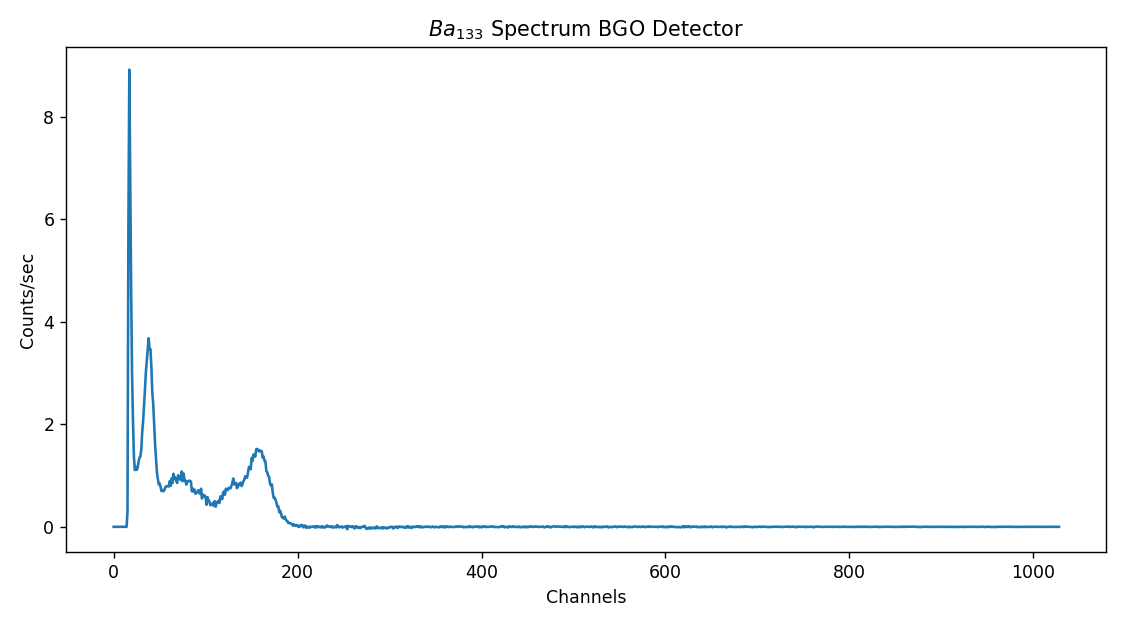

In [25]:
NaI_Ba_headers, NaI_Ba_channels, NaI_Ba_counts, NaI_Ba_counts_minus_bkg = plot_spectra(NaI_bkg_file, NaI_Ba_file)

<IPython.core.display.Javascript object>


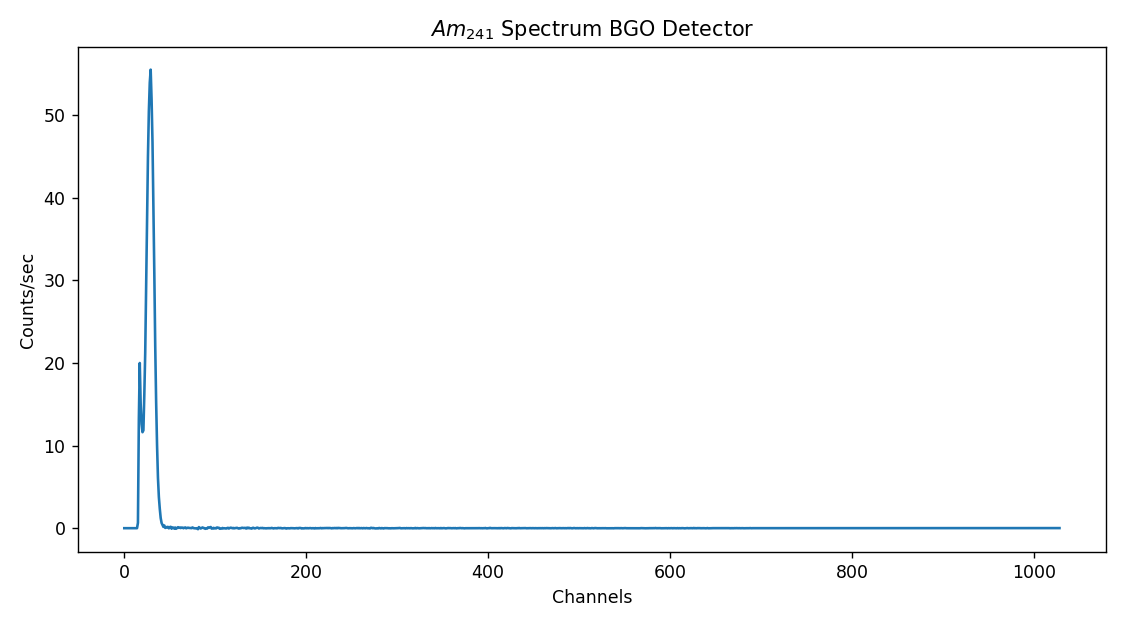

In [26]:
NaI_Am_headers, NaI_Am_channels, NaI_Am_counts, NaI_Am_counts_minus_bkg = plot_spectra(NaI_bkg_file, NaI_Am_file)

<IPython.core.display.Javascript object>


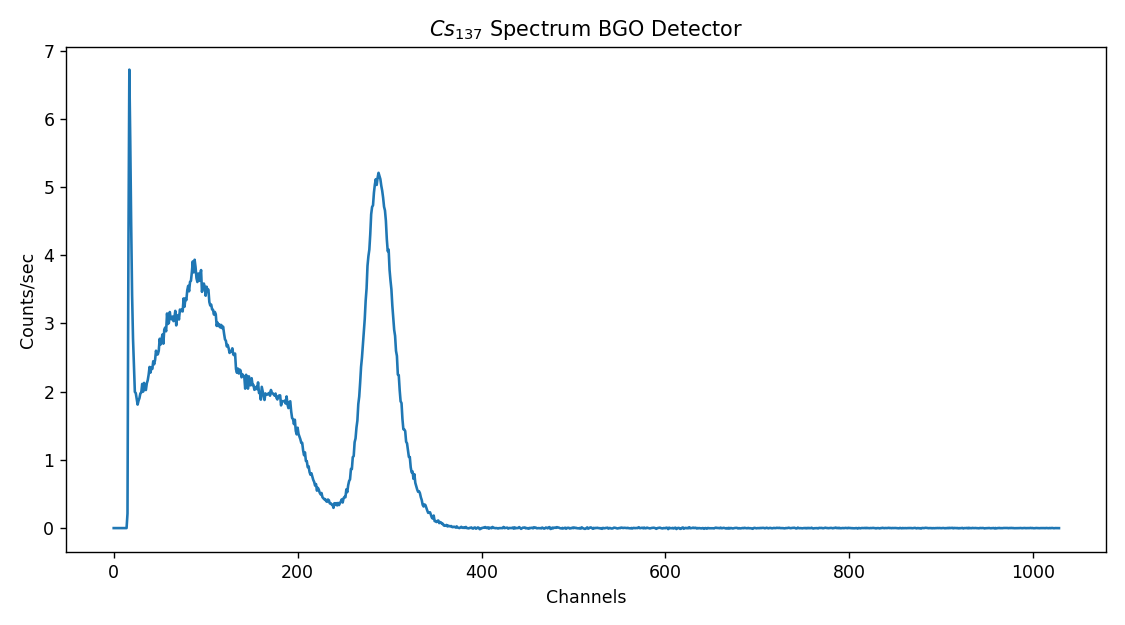

In [27]:
NaI_Cs_headers, NaI_Cs_channels, NaI_Cs_counts, NaI_Cs_counts_minus_bkg = plot_spectra(NaI_bkg_file, NaI_Cs_file)

<IPython.core.display.Javascript object>


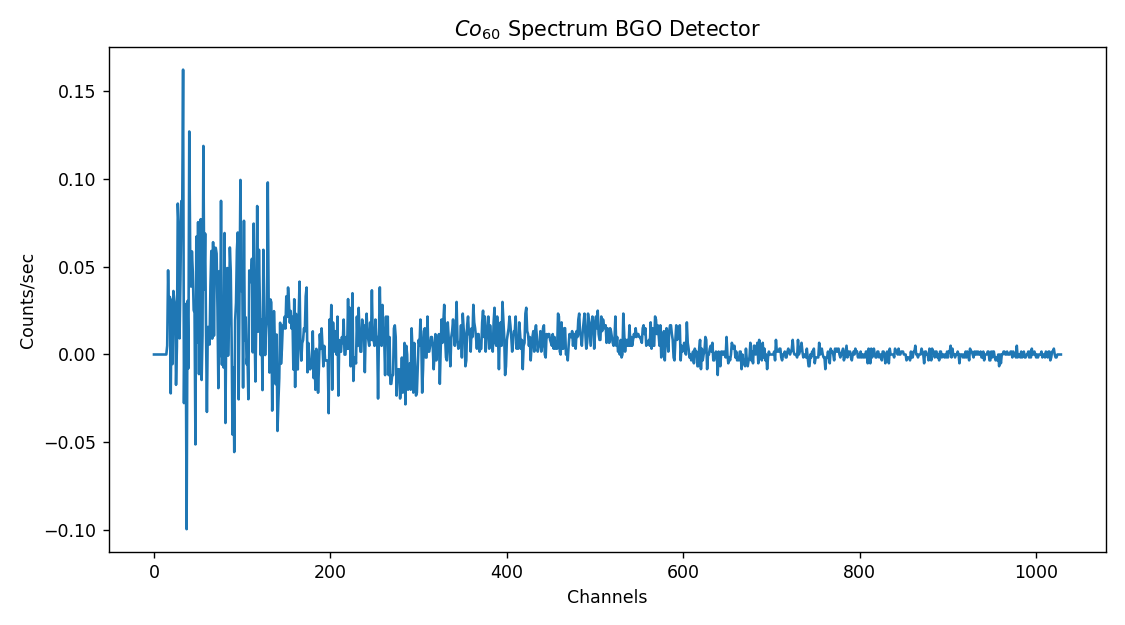

In [28]:
NaI_Co_headers, NaI_Co_channels, NaI_Co_counts, NaI_Co_counts_minus_bkg = plot_spectra(NaI_bkg_file, NaI_Co_file)

<IPython.core.display.Javascript object>


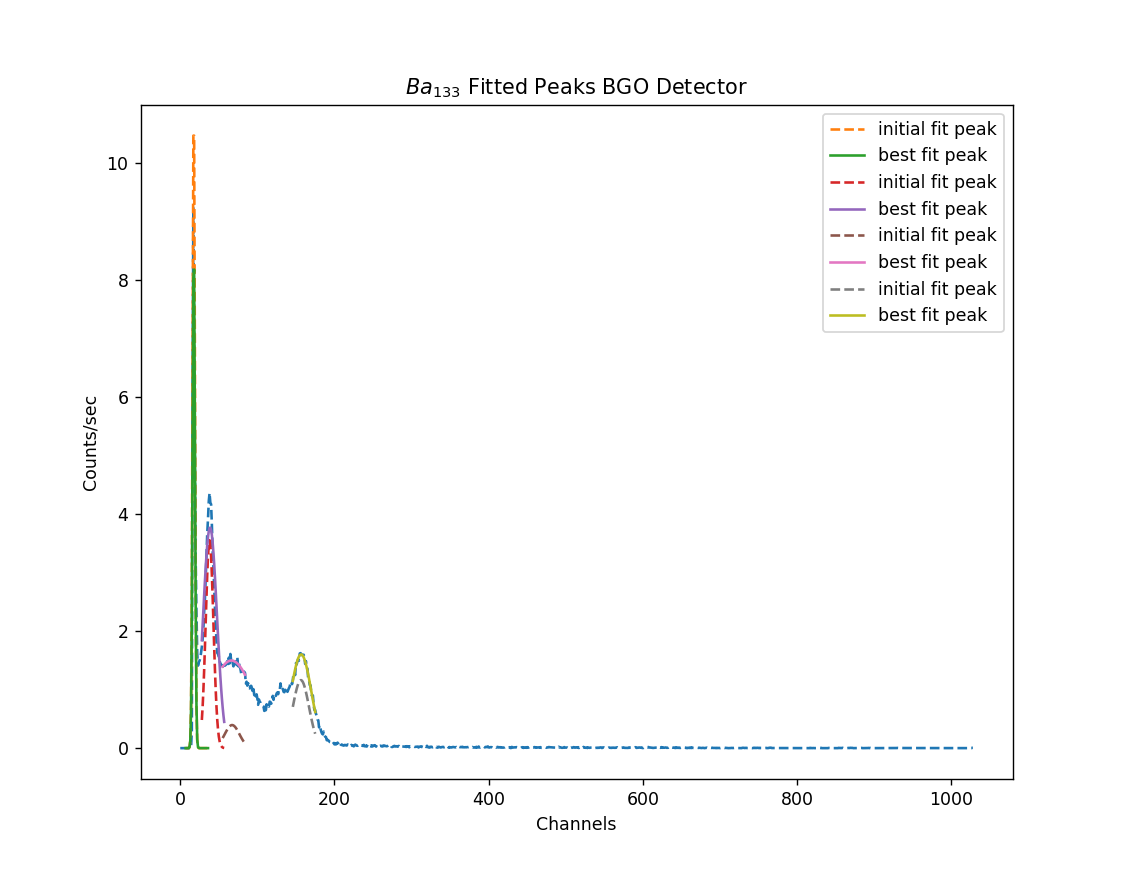

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [33]:
NaI_Ba_peaks, NaI_Ba_centroids, NaI_Ba_error = fitting_peaks(NaI_Ba_channels, NaI_Ba_counts, 10, 20, 0.5, 3, "$Ba_{133}$")

<IPython.core.display.Javascript object>


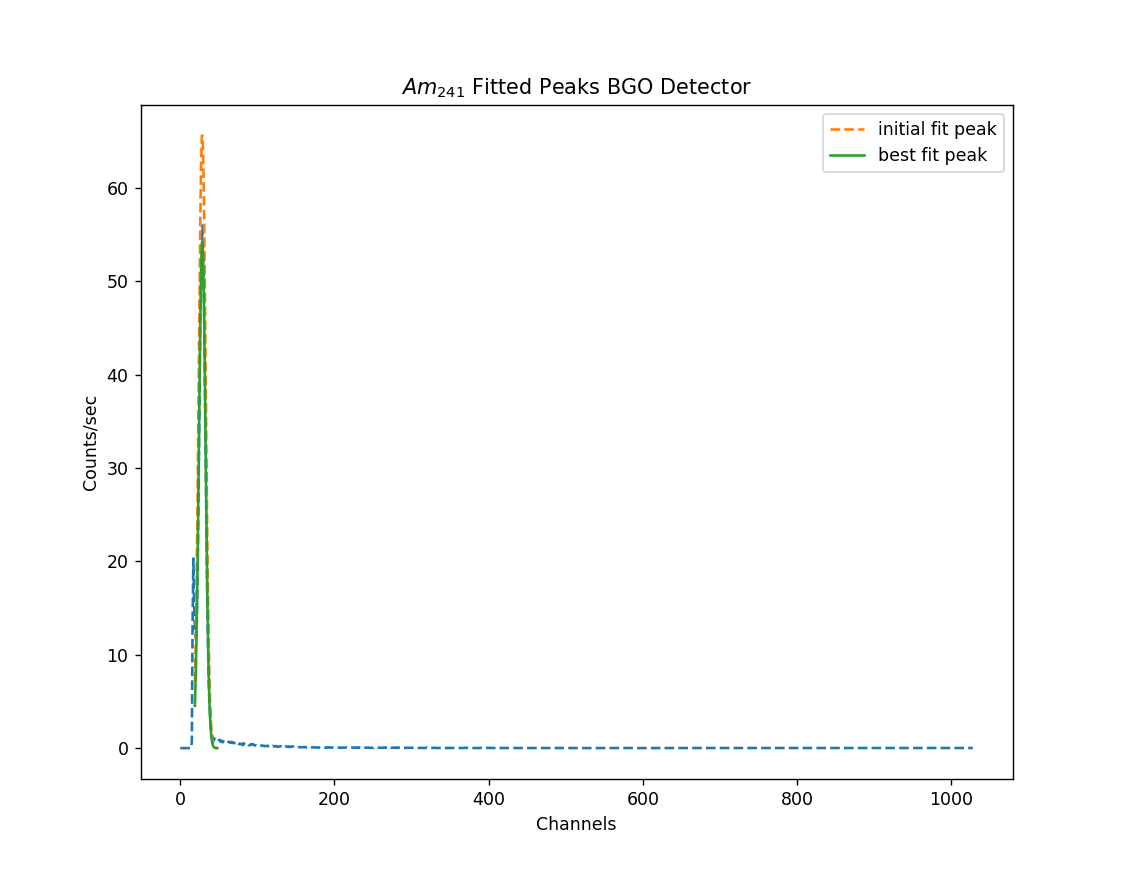

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [34]:
NaI_Am_peaks, NaI_Am_centroids, NaI_Am_error = fitting_peaks(NaI_Am_channels, NaI_Am_counts, 10, 20, 0.5, 3, "$Am_{241}$")

<IPython.core.display.Javascript object>


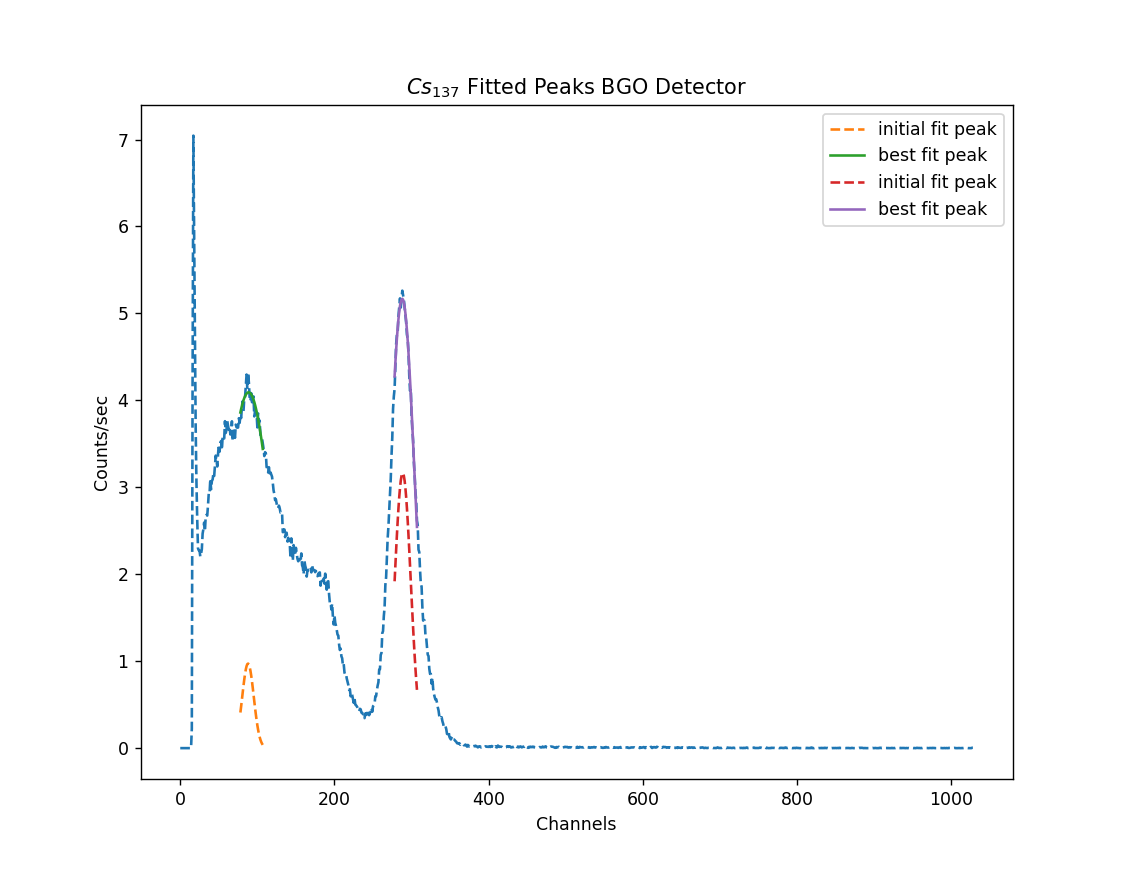

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [35]:
NaI_Cs_peaks, NaI_Cs_centroids, NaI_Cs_error = fitting_peaks(NaI_Cs_channels, NaI_Cs_counts, 10, 20, 2.5, 5, "$Cs_{137}$")

<IPython.core.display.Javascript object>


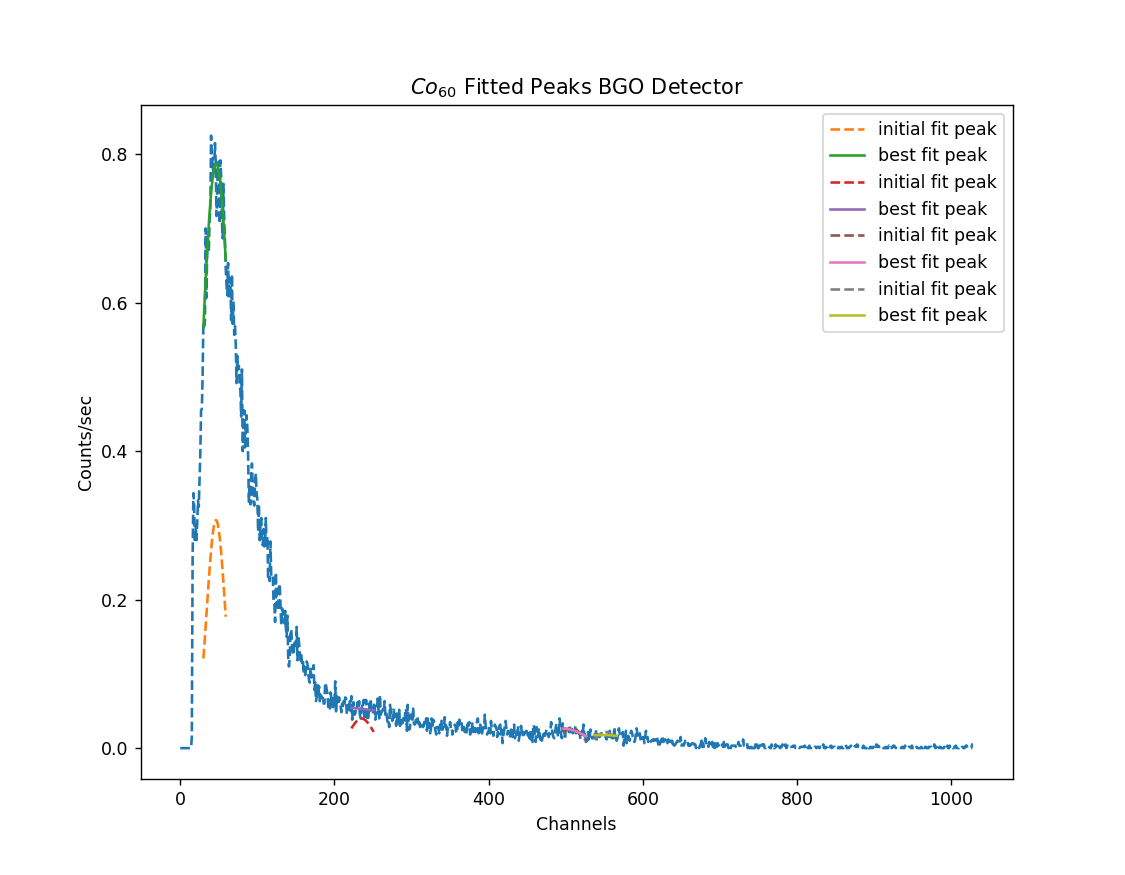

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [36]:
NaI_Co_peaks, NaI_Co_centroids, NaI_Co_error = fitting_peaks(NaI_Co_channels, NaI_Co_counts, 10, 20, 0.01, 5, "$Co_{60}$")

In [37]:
NaI_dictionary = {"Barium-133":[NaI_Ba_centroids, NaI_Ba_error],
                 "Americium-241":[NaI_Am_centroids, NaI_Am_error],
                 "Cobalt-60":[NaI_Co_centroids, NaI_Co_error],
                 "Caesium-137":[NaI_Cs_centroids, NaI_Cs_error]}

In [38]:
df = pd.DataFrame(data=NaI_dictionary)
df.to_csv('NaI_results.csv', index=False)

In [ ]:
# %load NaI_results.csv
Barium-133,Americium-241,Cobalt-60,Caesium-137
"[17.549120192926612, 38.63897038851976, 66.29479744082296, 156.77205515396352]",[28.527059994358893],"[46.63398715339283, -4460.209027260698, 497.377680033231, 543.0462113423674]","[88.65389415590998, 287.89000754040103]"
"[0.29366694926043746, 0.46627441533072594, 0.8356259071797071, 0.17648511227737398]",[0.08400400966985397],"[0.5255428031986749, 9519735.378841836, 16.308111026265212, 54.982978928255434]","[0.7083676199360922, 0.12894909794896922]"


In [42]:
def parse_mca_files(filename):
    IS_HEADER = False
    IS_DATA = False
    header_key = []
    header_value = []
    data = []

    with open(filename) as file:
        for line in file:
            line = line.strip()

            if line == "<<PMCA SPECTRUM>>":
                IS_HEADER = True
                IS_DATA = False
                continue

            elif line == "<<DATA>>":
                IS_HEADER = False
                IS_DATA = True
                continue

            elif line.startswith("<<END") or line.startswith("<<DP5 CONFIGURATION") or line.startswith("<<DPP STATUS"):
                IS_HEADER = False
                IS_DATA = False
                continue

            # handle header lines
            if IS_HEADER:
                if "-" in line:
                    header_split = line.split("-", 1)
                    header_key.append(header_split[0].strip())
                    header_value.append(header_split[1].strip())
            
            elif IS_DATA:
                try:
                    counts = int(line.strip())
                    data.append(counts)
                except ValueError:
                    # silently skip non-data lines
                    continue

    # build data dictionary
    channels = np.arange(len(data))
    counts = np.array(data)

    # create a dictionary for the headers using the lists of keys and values
    headers = {k: v for k, v in zip(header_key, header_value)}
    
    return headers, channels, counts

In [43]:
def plot_CdTe_spectra(bkg_file, file):
    headers, channels, counts = parse_mca_files(file)
    bkg_headers, bkg_channels, bkg_counts = parse_mca_files(bkg_file)
    
    time_bkg = bkg_headers["REAL_TIME"]
    bkg_exp_time = float(time_bkg)
    
    bkg_counts_per_sec = counts_per_sec(np.array(bkg_counts), bkg_exp_time)
    
    time_data = headers["REAL_TIME"]
    data_exp_time = float(time_data)
    
    counts_sec = counts_per_sec(np.array(counts), data_exp_time)
    
    counts_minus_bkg = (np.array(counts_sec) - np.array(bkg_counts_per_sec)).flatten()
    
    if "Am" in file:
        title = "$Am_{241}$"
        
    if "Co" in file:
        title = "$Co_{60}$"
        
    if "Ba" in file:
        title = "$Ba_{133}$"
        
    if "Cs" in file:
        title = "$Cs_{137}$"
    
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(channels, counts_minus_bkg, label=f"{title} Spectrum")
    ax.set_title(f"{title} Spectrum CdTe Detector")
    ax.set_xlabel("Channels")
    ax.set_ylabel("Counts/sec")
    plt.tight_layout()
    plt.show()
    
    return headers, channels, counts_sec, counts_minus_bkg

In [44]:
CdTe_Am_file = "CdTe_Am_direct.mca"
CdTe_Ba_file = "CdTe_Ba_direct.mca"
CdTe_Co_file = "CdTe_Co_direct.mca"
CdTe_Cs_file = "CdTe_Cs_direct.mca"
CdTe_bkg_file = "CdTe_bck_10min.mca"

<IPython.core.display.Javascript object>


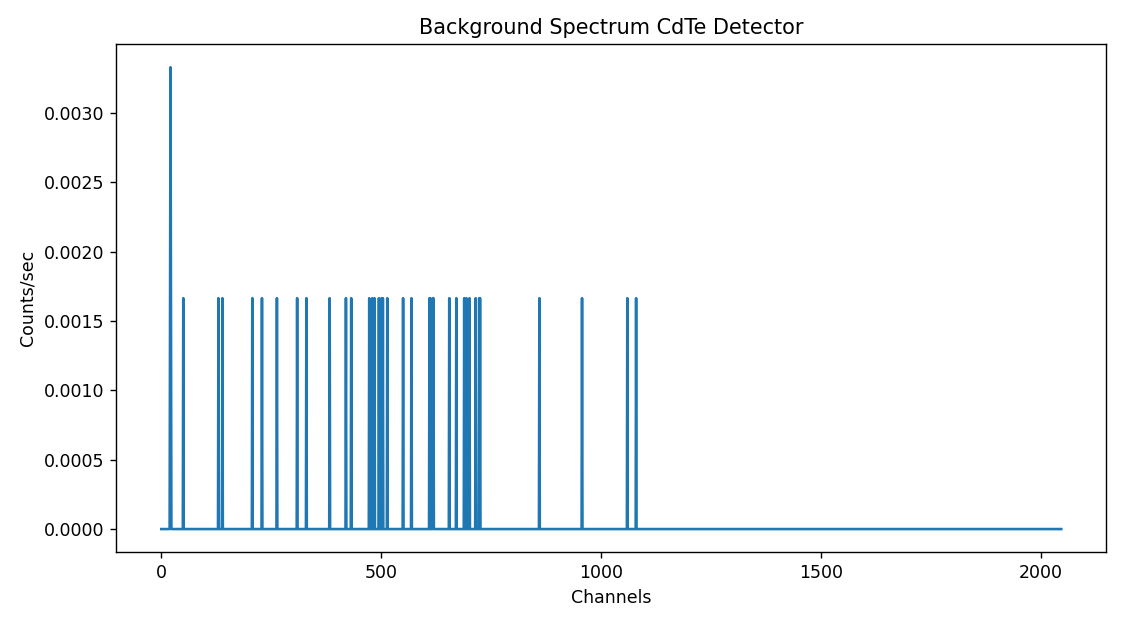

In [45]:
bkg_headers, bkg_channels, bkg_counts = parse_mca_files(CdTe_bkg_file)
    
time_bkg = bkg_headers["REAL_TIME"]
bkg_exp_time = float(time_bkg)
    
bkg_counts_per_sec = counts_per_sec(np.array(bkg_counts), bkg_exp_time)
    
fig, ax = plt.subplots(figsize=(9, 5))
ax.plot(bkg_channels, bkg_counts_per_sec, label="Background Spectrum")
ax.set_title("Background Spectrum CdTe Detector")
ax.set_xlabel("Channels")
ax.set_ylabel("Counts/sec")
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


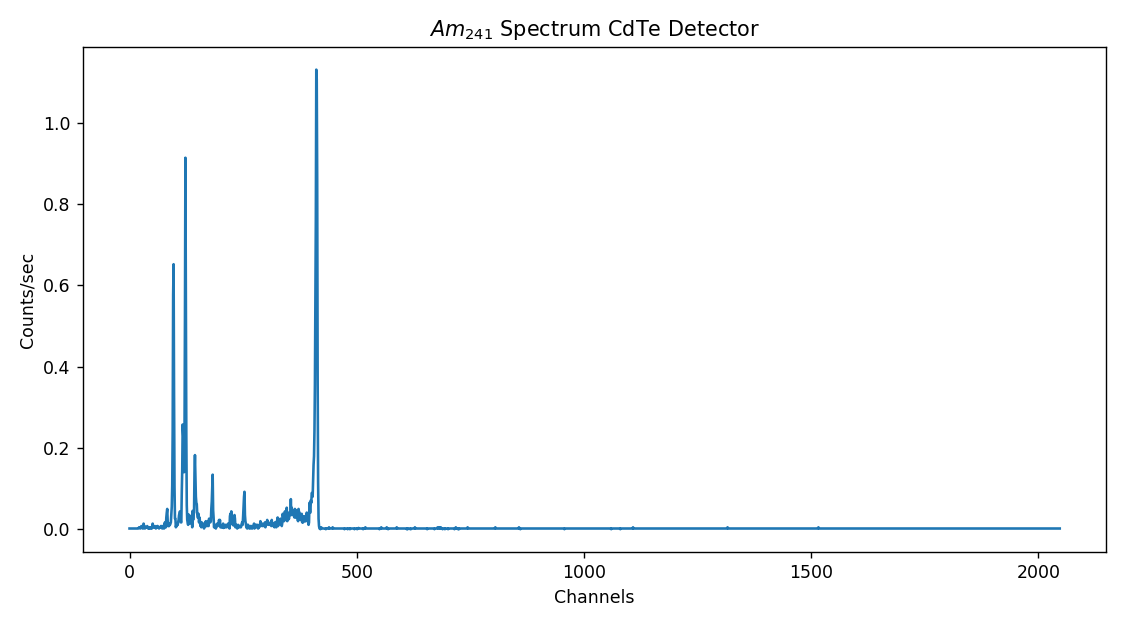

In [61]:
CdTe_Am_headers, CdTe_Am_channels, CdTe_Am_counts, CdTe_Am_minus_bkg = plot_CdTe_spectra(CdTe_bkg_file, CdTe_Am_file)

<IPython.core.display.Javascript object>


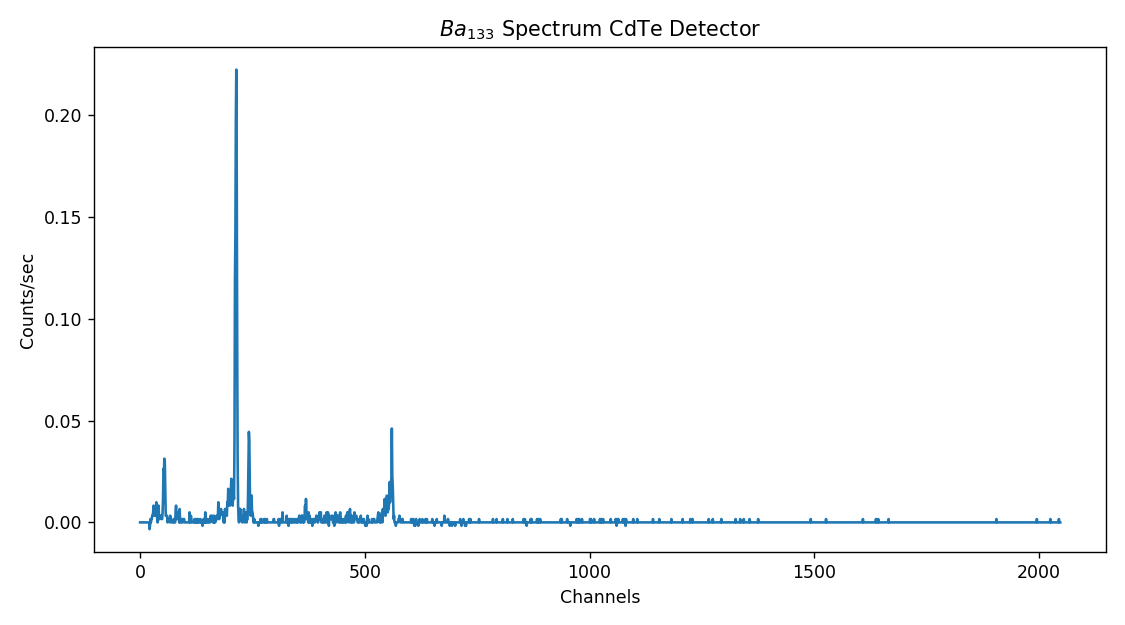

In [62]:
CdTe_Ba_headers, CdTe_Ba_channels, CdTe_Ba_counts, CdTe_Ba_minus_bkg = plot_CdTe_spectra(CdTe_bkg_file, CdTe_Ba_file)

<IPython.core.display.Javascript object>


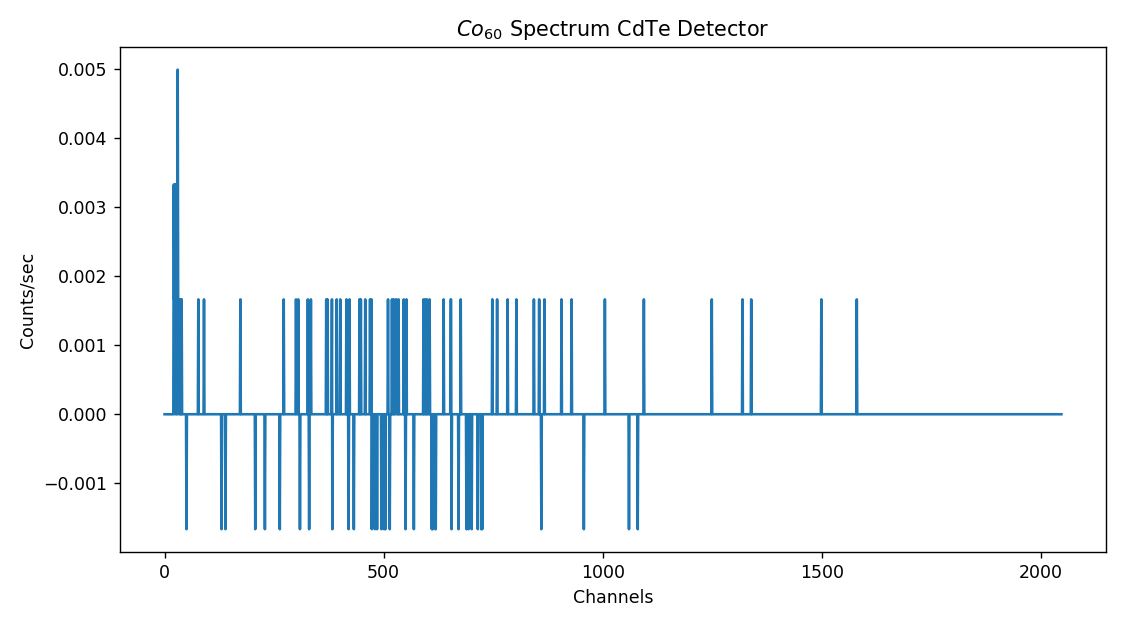

In [63]:
CdTe_Co_headers, CdTe_Co_channels, CdTe_Co_counts, CdTe_Co_minus_bkg = plot_CdTe_spectra(CdTe_bkg_file, CdTe_Co_file)

<IPython.core.display.Javascript object>


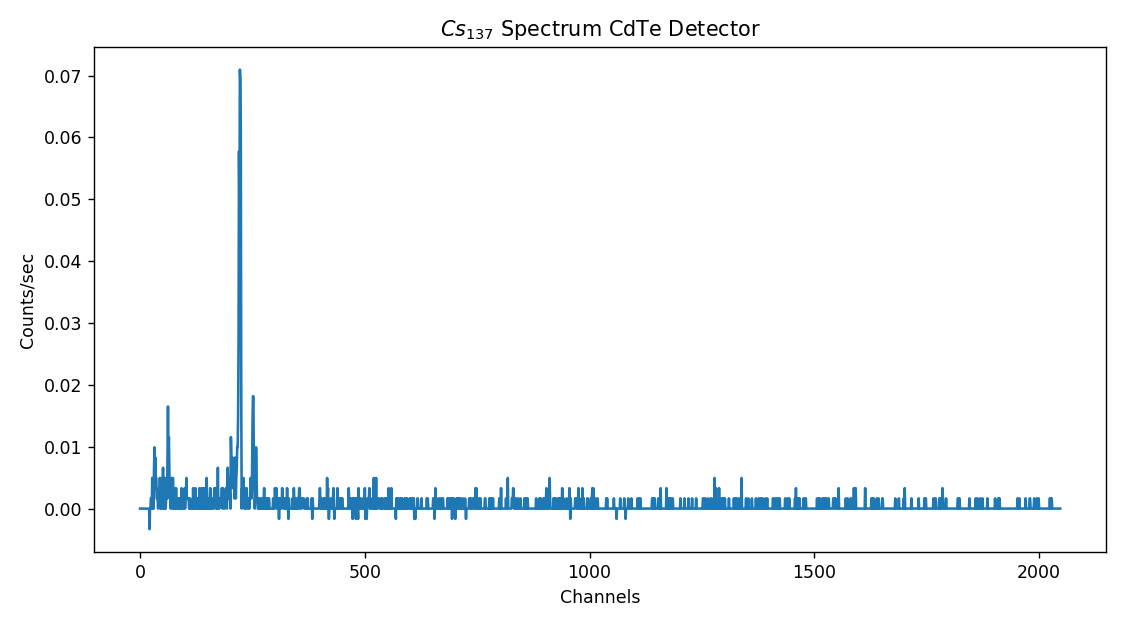

In [64]:
CdTe_Cs_headers, CdTe_Cs_channels, CdTe_Cs_counts, CdTe_Cs_minus_bkg = plot_CdTe_spectra(CdTe_bkg_file, CdTe_Cs_file)

In [65]:
def fitting_peaks_CdTe(channels, counts, lower, upper, height, width, title):
    # find peaks
    peaks, _ = find_peaks(counts, height=height, width=width)
    
    # loop through peaks and fit gaussian
    model = GaussianModel()
    
    gauss_peaks = []
    centroids = []
    centroid_error = []
    
    fig, ax = plt.subplots(figsize=(9, 7))
    ax.plot(channels, counts, "--")
    
    for peak in peaks:
        channel_range = np.arange((peak-lower), (peak+upper))
        
        params = model.guess(counts[channel_range], channels[channel_range])
        
        result = model.fit(counts[channel_range], x=channels[channel_range], params=params)
        
        # add result to peaks array
        gauss_peaks.append(result)
        centroids.append(result.params["center"].value)
        centroid_error.append(result.params["center"].stderr)
        
        ax.plot(channels[channel_range], result.init_fit, "--", label="initial fit peak")
        ax.plot(channels[channel_range], result.best_fit, "-", label="best fit peak")
        
    ax.set_title(f"{title} Fitted Peaks CdTe Detector")
    ax.set_xlabel("Channels")
    ax.set_ylabel("Counts/sec")
    ax.legend()
    plt.show()
        
    return gauss_peaks, centroids, centroid_error

<IPython.core.display.Javascript object>


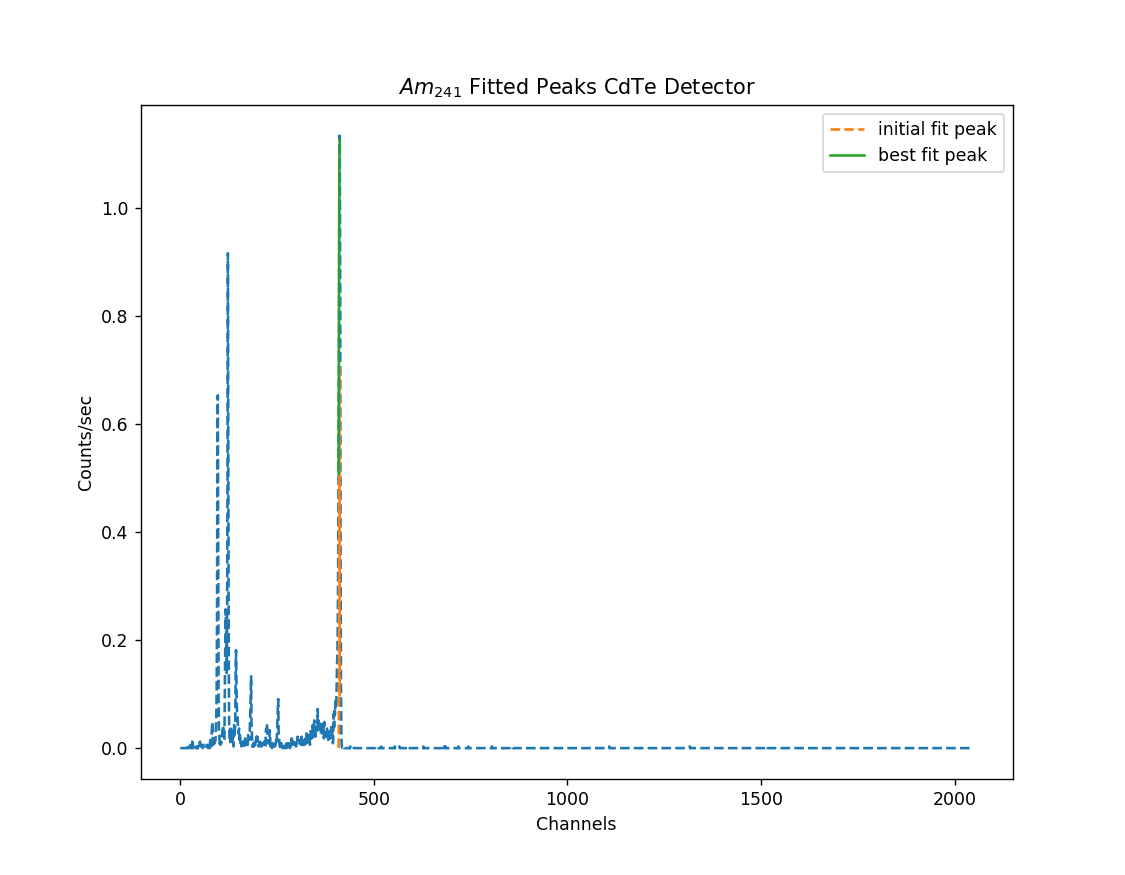

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [66]:
CdTe_Am_gauss_peaks, CdTe_Am_centroids, CdTe_Am_centroid_error = fitting_peaks_CdTe(CdTe_Am_channels, CdTe_Am_counts, 2, 2, 1.0, None, "$Am_{241}$")

<IPython.core.display.Javascript object>


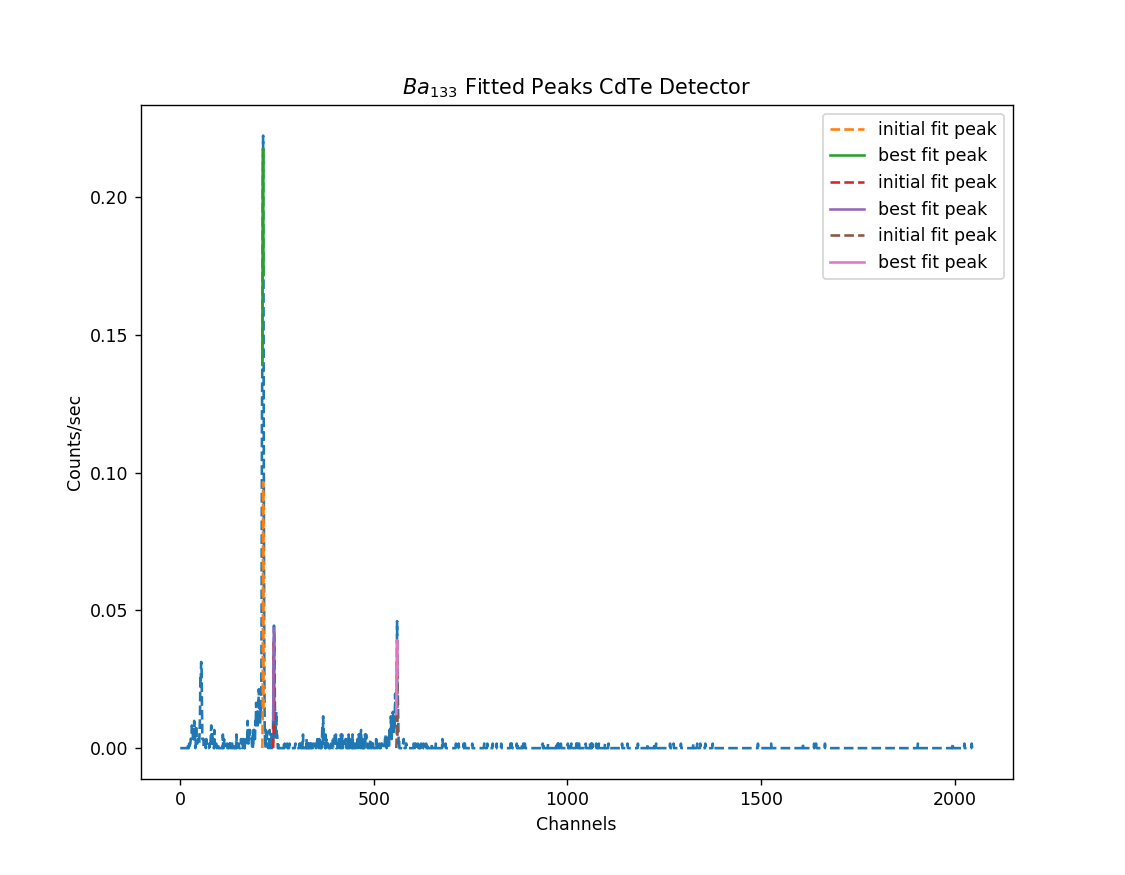

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [67]:
CdTe_Ba_gauss_peaks, CdTe_Ba_centroids, CdTe_Ba_centroid_error = fitting_peaks_CdTe(CdTe_Ba_channels, CdTe_Ba_counts, 2, 2, [0.04,0.25], None, "$Ba_{133}$")

<IPython.core.display.Javascript object>


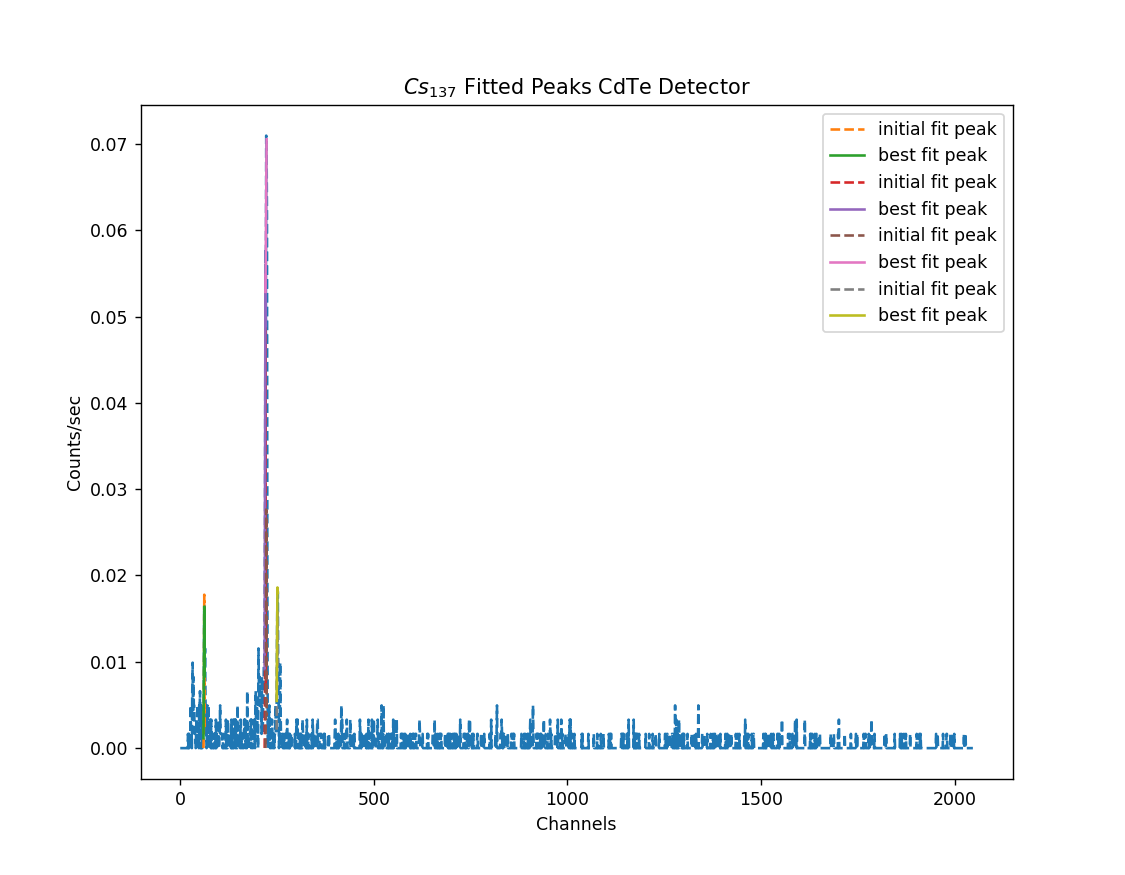

C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")
C:\ProgramData\Anaconda3\lib\site-packages\uncertainties\core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


In [68]:
CdTe_Cs_gauss_peaks, CdTe_Cs_centroids, CdTe_Cs_centroid_error = fitting_peaks_CdTe(CdTe_Cs_channels, CdTe_Cs_counts, 2, 2, [0.015,0.25], None, "$Cs_{137}$")

In [55]:
CdTe_dictionary = {"Barium-133":[CdTe_Ba_centroids, CdTe_Ba_centroid_error],
                 "Americium-241":[CdTe_Am_centroids, CdTe_Am_centroid_error],
                 "Caesium-137":[CdTe_Cs_centroids, CdTe_Cs_centroid_error]}

In [56]:
df = pd.DataFrame(data=CdTe_dictionary)
df.to_csv('CdTe_results.csv', index=False)

In [ ]:
# %load CdTe_results.csv
Barium-133,Americium-241,Caesium-137
"[213.72838719616902, 242.33456083139748, 559.8928962423558]",[411.67064164477443],"[61.993945194834225, 220.32894732082542, 627.2400532747567, 251.42142806367485]"
"[0.07411034341056055, 0.1006631865637716, 0.48963604989899084]",[0.5195831037852214],"[0.034867939101202644, 0.2572203440528581, None, 0.14690337394322647]"
